## Get user id list and count

In [1]:
# use shell script to count unique id (large file, slow)
import os
cmd="""
export LC_CTYPE=C 
export LANG=C
# get uid field| sort | count unique ids | strip blank spaces | output to file
cat ../data/play/all_play_log| cut -f1 -d$'\t'| sort | uniq -c | sed -e 's/^ *//g;s/ *$//g'> ../data/uid_count.csv
"""
os.system(cmd)

0

In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('../data/uid_count.csv',sep='\s+', names=['count','uid'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594735 entries, 0 to 594734
Data columns (total 2 columns):
count    594735 non-null int64
uid      594734 non-null float64
dtypes: float64(1), int64(1)
memory usage: 9.1 MB


In [5]:
df.describe()

,count,uid
count,5.947350e+05,5.947340e+05
mean,2.460525e+02,1.673628e+08
std,1.526662e+04,1.047142e+07
min,1.000000e+00,0.000000e+00
25%,9.000000e+00,1.680262e+08
50%,4.000000e+01,1.684782e+08
75%,1.740000e+02,1.687685e+08
max,7.501794e+06,1.692623e+08


## Remove bots and outliers

In [6]:
# We use matplotlib for plotting
import matplotlib.pyplot as plt

# This statement allow to display plot without asking to
%matplotlib inline

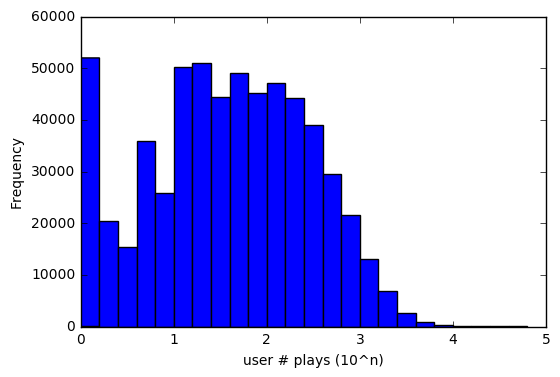

In [7]:
np.log10(df['count']).plot.hist(bins=np.arange(0,5,0.2))
plt.xlabel("user # plays (10^n)")

In [8]:
top_count_threshold = np.percentile(df['count'],99.9)
print(top_count_threshold)

5195.394


In [9]:
print("total number of users:",len(df['uid']))

('total number of users:', 594735)


In [10]:
# remove bots: get id with play counts<top_count_threshold
id_list_bot_removed = np.array(df['uid'][df['count']<top_count_threshold].dropna())

In [11]:
print("total number of users after bot removed:",len(id_list_bot_removed))

('total number of users after bot removed:', 594139)


# Apply downsample on uid level

In [12]:
# downsample ids
np.random.seed = 1
id_subset = set(id_list_bot_removed[np.random.random(id_list_bot_removed.shape)<0.1])

In [13]:
print("total number of users after down sample:",len(id_subset))

('total number of users after down sample:', 59361)


In [14]:
# define date conversion function
import datetime
def convert_date(s):
    s = str(s).strip()
    try:
        year = int(s[:4])
        month = int(s[4:6])
        day = int(s[6:8])
        return datetime.date(year,month,day)
    except:
        return None

In [15]:
# down sample play by uid
import csv
input_file = '../data/play/all_play_log'
output_file = '../data/play_ds.csv'
input_field_list = ['uid','device','song_id','song_type','song_name','singer','play_time','song_length','paid_flag','date']
output_field_list = ['uid','device','song_id','date','play_time','song_length']
i=0
with open(input_file,'r',encoding='latin-1') as fin, open(output_file,'w') as fout:
    csvin = csv.DictReader(fin,delimiter='\t',fieldnames=input_field_list,quoting=csv.QUOTE_NONE)
    csvout = csv.writer(fout,delimiter=',')
    csvout.writerow(output_field_list) # write header
    for row in csvin:
        i+=1
        if i%1000000==0:
            print("#row processed:",i)
        try:
            int(row['uid'])
        except:
            continue
        if int(row['uid']) in id_subset:
            row['date'] = convert_date(row['date'])
            if row['date'] != None: 
                csvout.writerow([str(row[key]).strip() for key in output_field_list])

TypeError: 'encoding' is an invalid keyword argument for this function

In [ ]:
# down sample download by uid
import csv
input_file = '../data/down/all_down_log'
output_file = '../data/down_ds.csv'
input_field_list = ['uid','device','song_id','song_name','singer','paid_flag','date']
output_field_list = ['uid','device','song_id','date']
i=0
with open(input_file,'r',encoding='latin-1') as fin, open(output_file,'w') as fout:
    csvin = csv.DictReader(fin,delimiter='\t',fieldnames=input_field_list,quoting=csv.QUOTE_NONE)
    csvout = csv.writer(fout,delimiter=',')
    csvout.writerow(output_field_list) # write header
    for row in csvin:
        i+=1
        if i%1000000==0:
            print("#row processed:",i)
        try:
            int(row['uid'])
        except:
            continue
        if int(row['uid']) in id_subset:
            row['date'] = convert_date(row['date'])
            if row['date'] != None: 
                csvout.writerow([str(row[key]).strip() for key in output_field_list])


In [ ]:
# down sample search by uid  
import csv
input_file = '../data/search/all_search_log'
output_file = '../data/search_ds.csv'
input_field_list = ['uid','device','time_stamp','search_query','date']
output_field_list = ['uid','device','date']
i=0
with open(input_file,'r',encoding='latin-1') as fin, open(output_file,'w') as fout:
    csvin = csv.DictReader(fin,delimiter='\t',fieldnames=input_field_list,quoting=csv.QUOTE_NONE)
    csvout = csv.writer(fout,delimiter=',')
    csvout.writerow(output_field_list) # write header
    for row in csvin:
        i+=1
        if i%1000000==0:
            print("#row processed:",i)
        try:
            int(row['uid'])
        except:
            continue
        if int(row['uid']) in id_subset:
            row['date'] = convert_date(row['date'])
            if row['date'] != None: 
                csvout.writerow([str(row[key]).strip() for key in output_field_list])


# Create event table for feature generation

In [ ]:
play_file = '../data/play_ds.csv'
down_file = '../data/down_ds.csv'
search_file = '../data/search_ds.csv'
output_file = '../data/event_ds.csv'
play_field_list = ['uid','device','song_id','date','play_time','song_length']
down_field_list = ['uid','device','song_id','date']
search_field_list = ['uid','device','date']
output_field_list = ['uid','event','song_id','date']
with open(play_file,'r') as f_play, open(down_file,'r') as f_down, \
open(search_file,'r') as f_search,open(output_file,'w') as f_out:
    csvplay = csv.DictReader(f_play,delimiter=',')
    csvdown = csv.DictReader(f_down,delimiter=',')
    csvsearch = csv.DictReader(f_search,delimiter=',')
    csvout = csv.writer(f_out,delimiter=',')
    csvout.writerow(output_field_list) # write header
    print('Processing play ...')
    for row in csvplay:
        row['event'] = 'P'
        row['date']
        csvout.writerow([row[key] for key in output_field_list])
    print('Processing down ...')
    for row in csvdown:
        row['event'] = 'D'
        csvout.writerow([row[key] for key in output_field_list])
    print('Processing search ...')
    for row in csvsearch:
        row['event'] = 'S'
        csvout.writerow([row.get(key,'') for key in output_field_list])
